## Business forecasting with Facebook Prophet

```
https://futurice.com/blog/business-forecasting-with-facebook-prophet
```

### A short note on the data

For this imaginary example, I’ve made a dataset by combining real world data from the Norwegian road authorities and the Norwegian Meteorological Institute. More specifically the data is counting bike commuters on a specific stretch in Oslo, Norway at Ullevål. You can download the data her:

```
https://github.com/pixelbakker/datasets/blob/master/bikerides_day.csv
```

### The plan

Before we start working we make a brief work breakdown as follows:

- Visually inspect the data and control for missing data and outliers
- If needed, transform the data
- Make a first prediction model without any tuning and validate the model.
- Tune and test the model with the addition of special events and dates
- Tune and test the model with rainfall and temperature as additional regressors.
- Tuning hyperparameters

### A first look at the data

For brevity, I've chosen to provide a cleaned dataset so that we can spend most of our time with actual analysis and not sorting out bad data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import warnings
#warnings.filterwarnings("ignore")

pd.set_option('display.max_row', 1000)

# Read the data
# NOTE: You must change the path to reflect your environment
bikerides = pd.read_csv('../examples/bikerides_day.csv', encoding='unicode_escape', delimiter=',')
# Convert Date to datetime
bikerides['Date'] = pd.to_datetime(bikerides['Date'])
bikerides.head()

,Date,Volume,Rain,Temp
0,2016-11-17,933.0,9.0,2.1
1,2016-11-18,1197.0,6.7,3.9
2,2016-11-19,243.0,5.4,2.0
3,2016-11-20,234.0,3.9,2.8
4,2016-11-21,2148.0,7.3,2.8


Prophet is expecting columns to have specific names, `ds` for the temporal part and `y` for the value part. So we adhere to that.

In [2]:
# Rename the columns to Prophet scheme who expect date column to be named "ds" and data column to called "y"
bikerides.columns = ['ds', 'y', 'rain', 'temp']
bikerides.head(1)

,ds,y,rain,temp
0,2016-11-17,933.0,9.0,2.1


It's always a good idea to plot the data to get a first impression on what we are dealing with. I use plotly for custom charts - it's good.

In [3]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Rides',))

### Removing weekend rides

We can see that the data has clear seasonality and maybe a slight positive trend although that is harder to see. We can also notice quite a lot of variability. Some of the variability is probably caused by weekends when people are not commuting to work. Let’s remove all the weekends from our data and see how it looks.

In [4]:
# Removing weekends
bikerides.set_index('ds', inplace=True)
bikerides = bikerides[bikerides.index.dayofweek < 5].reset_index()
# Plot
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Rides',))

### Applying Box Cox transformation

For time-series it's often useful to do some form of power transform of the data to stabilise variance and make the data more normal distribution-like. But what transformation to use for the best result? Fortunately, we can use a Box Cox transformation that evaluates a set of lambda coefficients (λ) and selects the value that achieves the best approximation of normality. We can do it like so:

In [5]:
# Apply Box-Cox Transform and save the lambda for later inverse.
bikerides['y'], lam = boxcox(bikerides['y'])
print('Lambda is:', lam)

Lambda is: 0.45166936452584744


In [6]:
# Plot
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Rides',))

### Forecasting with prophet - a first take

The Prophet code flow is really simple: First get hold of a Prophet instance and fit a model with our bike rides data frame. Then we create a data frame holding the prediction dates (horizon) and pass that into the Prophet predict method, like so:

In [7]:
# Get hold of the Prophet object
m = Prophet()
 
# Fit the data. Remember that prophet expect "ds" and "y" as names for the columns.
m.fit(bikerides)
 
# We must create a data frame holding dates for our forecast. The periods # parameter counts days as long as the frequency is 'D' for the day. Let's # do a 180 day forecast, approximately half a year.
future = m.make_future_dataframe(periods=180, freq='D')
# Create the forecast object which will hold all of the resulting data from the forecast.
forecast = m.predict(future)
# List the predicted values with a lower and upper band.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -33.7767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1699.11   2.20385e-06       70.4781      0.2017      0.2017      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       1699.13   2.52731e-07       63.7518       1.111      0.4045      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


When listing the forecast data-frame we get:

In [8]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1084,2020-11-12,79.236680,62.281068,95.138494
1085,2020-11-13,73.752692,57.495820,89.536180
1086,2020-11-14,60.938161,44.644011,77.539372
1087,2020-11-15,60.323684,44.681702,76.562335
1088,2020-11-16,80.453950,65.064694,95.969526


The yhat-column contains the predictions and then you have lower and upper bands of the predictions. Although the forecast data frame contains all the data you need to make your own plots, Prophet also provides convenience methods for plotting. For brevity, we are going to use the built-in methods where we can, but when needed, we’ll make our own custom plots with plotly. Plotting our forecast with Prophet can be done like so:

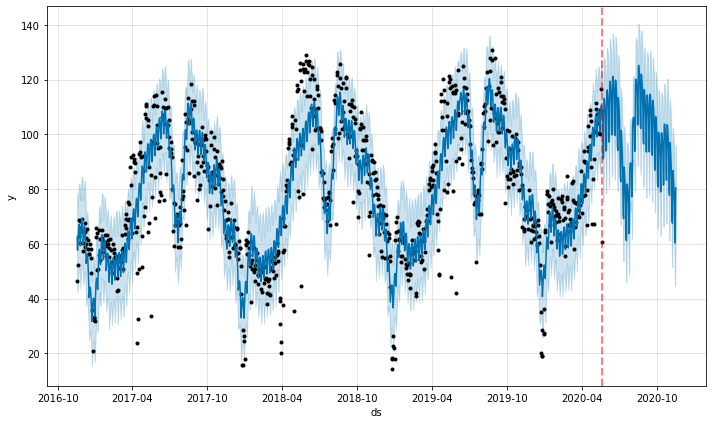

In [9]:
# Plotting with Prophet built-in method
fig = m.plot(forecast)
plt.axvline(x=forecast['ds'].max() - pd.Timedelta('180 days'), c='red', lw=2, alpha=0.5, ls='--')

You can also add change-points (where the trend model is shifting) to the plot like this:

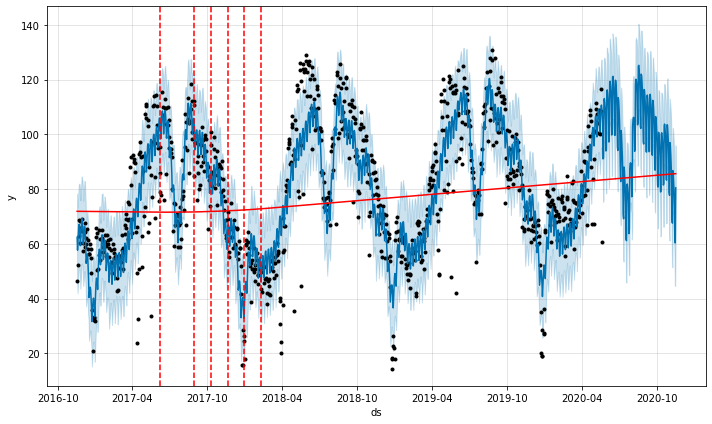

In [10]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

If we want we can also plot all the components that make up the model: trend, different seasonalities and holidays - we’ll cover that in more detail later on. For now let’s just look at the components using the built-in plotting method.

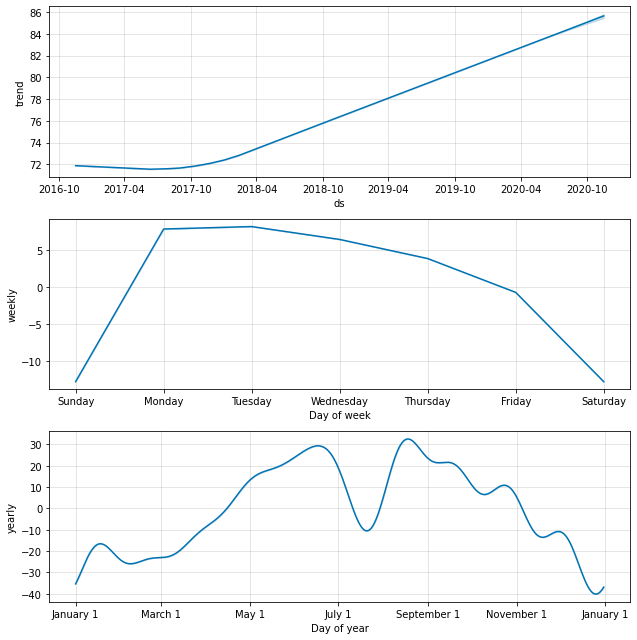

In [11]:
fig = m.plot_components(forecast)

We can see that we have a clear positive trend and that Monday and Tuesday are the days when most people commute. We also see a strong yearly seasonality.

### Validating our results

The Prophet library makes it possible to divide our historical data into training data and testing data for cross validation. The main concepts for cross validation with Prophet are:

- Training data (initial): The amount of data set aside for training. The parameter is in the API called initial.
- Horizon: The data set aside for validation. If you don’t define a period the model will be fitted with Horizon/2.
- Cutoff (period): a forecast is made for every observed point between cutoff and cutoff + horizon.

The resulting data frame can now be used to compute error measures of yhat vs. y. Below I’ve plotted a chart with some markers to help you understand in a more visual way. In this example, we have a one year horizon and the model will make predictions for each month (~31 days).

INFO:prophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00
  0%|          | 0/6 [00:00<?, ?it/s]

Initial log joint probability = -19.3489
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1010.58   5.72672e-05       56.1627      0.9703     0.09703      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       1010.82   6.77073e-05       63.1967   9.803e-07       0.001      288  LS failed, Hessian reset 
     199       1010.83   8.74491e-05       76.1792           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1010.94   3.32204e-06       63.6096      0.3446      0.3446      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       1010.94   6.09085e-08       55.0105      0.2403           1      474   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 17%|█▋        | 1/6 [00:02<00:10,  2.07s/it]

Initial log joint probability = -23.3632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1037.47   8.02346e-05       71.0411           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       1037.49   6.14083e-05       71.4676   7.495e-07       0.001      265  LS failed, Hessian reset 
     199       1037.49   7.98089e-07       86.3705      0.3812           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       1037.49   1.15116e-07       68.2656      0.7078      0.7078      368   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 33%|███▎      | 2/6 [00:04<00:08,  2.11s/it]

Initial log joint probability = -23.0053
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1083.45   1.82645e-05       75.7148       1.647      0.4525      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       1083.46   0.000108029       61.2536   1.261e-06       0.001      202  LS failed, Hessian reset 
     146       1083.46   6.48639e-09       63.1293     0.07049           1      246   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 50%|█████     | 3/6 [00:06<00:06,  2.10s/it]

Initial log joint probability = -18.4779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1134.36   7.71581e-05       68.7079           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       1134.37   0.000136825       89.2979   2.013e-06       0.001      191  LS failed, Hessian reset 
     168       1134.43   0.000559374       69.2804   6.665e-06       0.001      296  LS failed, Hessian reset 
     199       1134.44   6.37727e-07       68.6606      0.6649      0.6649      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       1134.44   6.28343e-08        54.986       1.164      0.3352      356   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 67%|██████▋   | 4/6 [00:08<00:04,  2.05s/it]

Initial log joint probability = -27.8141
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1165.11   0.000261941       111.636      0.4722      0.4722      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       1165.21   1.40797e-05       86.9597   1.979e-07       0.001      276  LS failed, Hessian reset 
     199       1165.21   1.01216e-07       77.0587      0.5668      0.5668      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       1165.21    2.8134e-08       60.3734      0.2716      0.2716      321   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 83%|████████▎ | 5/6 [00:10<00:02,  2.01s/it]

Initial log joint probability = -19.8695
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       1190.83    0.00169341       187.018   1.359e-05       0.001      159  LS failed, Hessian reset 
      99       1191.09    0.00127292       102.674           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       1192.25   0.000724728       88.4697   9.043e-06       0.001      224  LS failed, Hessian reset 
     199       1192.32     0.0014578       79.4873           1           1      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       1192.38   8.70162e-08       77.7885      0.1818      0.8622      380   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


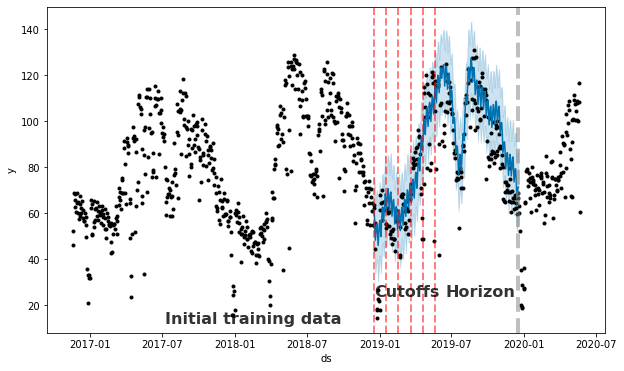

In [12]:
# Fit the model with two years of data and define a horizon of 365 days forcasting per month
df_cv = cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')
cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(m.history['ds'].values, m.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
#ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

# Making all the vlines for cutoffs
for item in cutoffs:
  ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

# Adding text to describe the data set splits
ax.text(x=pd.to_datetime('2017-07-07'),y=12, s='Initial training data', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2018-12-17'),y=24, s='Cutoffs', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime(cutoff) + pd.Timedelta('180 days'),y=24, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')

### Getting the performance metrics

So we have now made our first forecast with the Prophet library. But how do we know if the results are any good? Fortunately, Prophet comes with some built-in performance metrics that can help us out. I'm not going into the details when it comes to which metrics to use and leave that up to you. The performance metrics available are:

- MSE: mean squared error
- RMSE: root mean squared error
- MAE: mean absolute error
- MAPE: mean absolute percentage error
- MDAPE: median absolute percentage error

Listing the performance data frame gives us the following:

In [13]:
df_p = performance_metrics(df_cv)
df_p.head(5)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,362.492587,19.039238,14.062407,0.574090,0.133752,0.333943,0.72
1,37 days,365.459142,19.116986,14.339916,0.578745,0.146571,0.338179,0.72
2,38 days,365.852668,19.127276,14.385765,0.579194,0.146571,0.338596,0.72
3,39 days,367.465376,19.169386,14.559789,0.582433,0.146571,0.341500,0.72
4,42 days,378.916451,19.465776,15.097945,0.592496,0.152722,0.349739,0.68


To see how our model performs over time up to the horizon we can use the built-in plot called

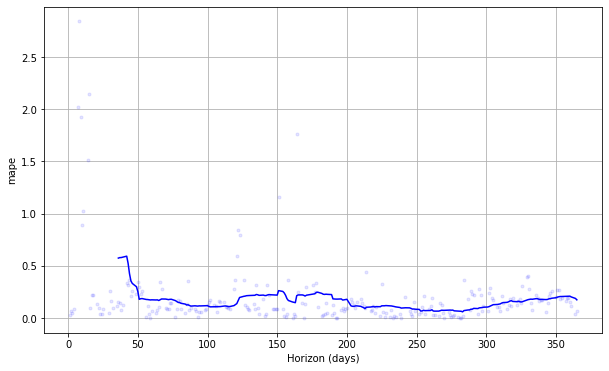

In [14]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

As we proceed we want to compare our validation results, so I've chosen to make a spreadsheet on the side in which to store the intermediate results. Also, since we use transformed numbers (remember the Box Cox) we just use the percentage error metrics. To keep track, we collect the mean aggregated data from our cross validation like this:

In [15]:
df_p.mean()

horizon     199 days 23:35:10.344827586
mse                          210.123327
rmse                          13.749836
mae                           11.106503
mape                            0.16396
mdape                          0.105676
smape                          0.138886
coverage                       0.781552
dtype: object

||No config|Added holidays|Added regressors|Hyperparameters
|:---:|---:|---:|---:|---:|
|mape|0.16396||||
|mdape|0.105676||||

Before moving on to improve our forecast model we’ll add two utility functions so we don't need to change data all over the place if we want to test different cross validation set-ups. They look like this:

In [16]:
def getPerformanceMetrics(m):
  return performance_metrics(getCrossValidationData(m))

def getCrossValidationData(m):
 return cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days', parallel="processes")

### Improving our forecast

### Adding holidays

Prophet has several ways of adding holidays and special events. The easiest and most convenient one is to use the built-in national holidays. The holidays for each country are provided by the holidays package in Python. A list of available countries, and the country name to use, is available on their page: `https://github.com/dr-prodigy/python-holidays`. We need Norwegian holidays so we do it like this:

In [17]:
m = Prophet()
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
# List the holiday names
m.train_holiday_names

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -33.7767


0         Første nyttårsdag
1           Arbeidernes dag
2              Grunnlovsdag
3            Første juledag
4             Andre juledag
5              Skjærtorsdag
6                Langfredag
7           Første påskedag
8            Andre påskedag
9     Kristi himmelfartsdag
10          Første pinsedag
11           Andre pinsedag
dtype: object

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1855.82   0.000319896       88.0825      0.3352           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       1856.14   0.000700704       164.596    7.59e-06       0.001      179  LS failed, Hessian reset 
     151       1856.29   1.68503e-05        82.753   2.252e-07       0.001      274  LS failed, Hessian reset 
     181       1856.29   3.63927e-06       78.3367   4.911e-08       0.001      354  LS failed, Hessian reset 
     197       1856.29   1.45651e-07       60.3658      0.3481           1      375   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


The last line of code lists all the built-in holidays and from the looks of it, the listing seems to be correct, although it could be augmented with dates for Christmas Eve or New Years eve and maybe others - but it’s a start. If we want to see the forecast and the effects made by the holidays regressors we can plot it like this:

In [18]:
future = m.make_future_dataframe(periods=0, freq='D')
future = future.merge(bikerides, on='ds')
forecast = m.predict(future)

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))

If we look at the cross validation data we can see that the model fits both May 1 and 17 very well but Ascension Day on May 30 2019, not so much. In addition Ascension Day in 2019 is on a Thursday and that tends to make people take Friday off in Norway. We can see this in the plot if we zoom in.

![](Ascension.png)

We are not particularly impressed with the Christmas model fits either. If we zoom in on the plot for 2019 we can see this:

![](Christmas.png)

Fortunately Prophet gives us the opportunity to add our own holidays and special dates. To see if we get an improved forecast we’ll add some additional dates for the model to take into account. Like so:

In [19]:
ascensionday = pd.DataFrame({
  'holiday': 'AscensionDay',
  'ds': pd.to_datetime(['2019-05-30']),
  'lower_window': 0,
  'upper_window': 1,
})

christmas = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2017-12-24','2018-12-24','2019-12-24','2020-12-24']),
  'lower_window': -1,
  'upper_window': 7,
})

holidays = pd.concat((ascensionday, christmas))

m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
future = m.make_future_dataframe(periods=0, freq='D')
forecast = m.predict(future)

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -33.7767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1911.98    0.00254306       75.0722           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1912.99   4.03436e-05       68.8585           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       1912.99   7.11812e-08       69.7752      0.5447      0.5447      284   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


The new plots show impressive improvements. Below you can see the plot for Christmas 2019 which now has been perfectly fitted.

![](Christmas2.png)

We leave the holidays for now, but before we move on, let’s gather some performance data and update our performance table:

In [20]:
getPerformanceMetrics(m).mean()

INFO:prophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x13c866970>


Initial log joint probability = -23.3632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1193.7    0.00331364       77.2122           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1194.66   2.30756e-05       84.8059      0.5408      0.5408      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -19.8695
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1194.68   1.40248e-06        67.738      0.4696      0.4696      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1369.69     0.0211765       118.502      0.1568           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     384        11

horizon     201 days 00:00:00
mse                123.460758
rmse                11.045467
mae                  8.449931
mape                  0.11236
mdape                  0.0832
smape                0.104424
coverage             0.774725
dtype: object

||No config|Added holidays|Added regressors|Hyperparameters
|:---:|---:|---:|---:|---:|
|mape|0.16396|0.11236|||
|mdape|0.105676|0.0832|||

### Adding extra regressors

If we look at the plot it doesn’t look half bad but can we improve our forecast? Remember we had some extra weather data? Let’s see if adding those as extra regressors will have any effect. Adding extra regressors is pretty straightforward but remember if you are going to use some in your forecast model you need to have the data present beforehand. With weather data this can be accomplished with weather forecasts. IMHO, the easiest and most solid extra regressors you can use are holidays and special dates that you know about, so I encourage you to do some extra work on those. But back to the weather data. We can add the rain and temperature data as extra regressors to the model like this (note that it’s only two code lines that change but I leave the whole listing for easy execution):

In [21]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='NO')
# Adding the extra weather regressors
m.add_regressor('rain')
m.add_regressor('temp')

m.fit(bikerides)
future = m.make_future_dataframe(periods=0, freq='D')
future = future.merge(bikerides, on='ds')
forecast = m.predict(future)
fig = go.Figure()

# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['rain'], name='Rain',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['temp'], name='Temp',))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -33.7767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2041.23    0.00297667       152.981           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       2042.14   0.000153668       79.1091   2.362e-06       0.001      229  LS failed, Hessian reset 
     199       2042.16   6.75472e-06       83.2901       0.531       0.531      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2042.25   2.73139e-07       53.3549        0.59        0.59      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       2042.25   1.46285e-07       55.9139     0.05114           1      426   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Looking at the plot it’s obvious that both rain and temperature are having an impact on the forecast. Let’s gather the performance data and update our performance table:

In [22]:
getPerformanceMetrics(m).mean()

INFO:prophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x13d8004c0>


Initial log joint probability = -19.8695
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1470.29     0.0040754       117.008           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       1471.87   0.000923662       107.557   7.084e-06       0.001      206  LS failed, Hessian reset 
     199       1472.46   0.000820568       88.6609           1           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -23.3632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1473.78   3.25989e-05        71.097           1           1      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1279.18   0.000278597        72.441      0.6501      0.6501      119   

horizon     201 days 00:00:00
mse                 90.418335
rmse                 9.476899
mae                  6.861534
mape                 0.092358
mdape                0.061373
smape                0.086362
coverage             0.795692
dtype: object

It starting to look like something! Our mean absolute percentage error is now below 10%.


||No config|Added holidays|Added regressors|Hyperparameters
|:---:|---:|---:|---:|---:|
|mape|0.16396|0.11236|0.092358||
|mdape|0.105676|0.0832|0.061373||

### Tuning hyperparameters

Prophet has quite a few parameters for you to tune. I’m not going to delve into the details of all of them but below you can see code that you can use for testing different hyper-parameters in a loop and then pick the best ones. Remember that if you choose to test all of the parameters in one go the number of permutations will be many and the running time will be considerable. I chose to tune one parameter at a time and I left the parameter arrays that I started with in the comments for you to try out yourself.

In [23]:
'''
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):
    m = Prophet(holidays=holidays, **param_dict)
    m.add_country_holidays(country_name='NO')
    # Adding the extra weather regressors
    m.add_regressor('rain')
    m.add_regressor('temp')
    m.fit(history_df)
    df_cv = getCrossValidationData(m)
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

pd.set_option('display.max_colwidth', None)
param_grid = {                  
                'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.25, 0.5],
                'changepoint_range': [0.6, 0.7, 0.75, 0.8, 0.9],
                'holidays_prior_scale':[1.0, 5.0, 10.0, 15.0],
                'seasonality_prior_scale':[0.5, 1.0, 2.5, 5],
                'yearly_seasonality':[5, 10, 15, 20],
                'weekly_seasonality':[5, 10, 15, 20],
              }
metrics = ['horizon', 'rmse', 'mae', 'mape', 'mdape','params'] 
results = []

params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(bikerides, metrics, param_dict)
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df.mean()
'''

"\ndef create_param_combinations(**param_dict):\n    param_iter = itertools.product(*param_dict.values())\n    params =[]\n    for param in param_iter:\n        params.append(param) \n    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))\n    return params_df\n\ndef single_cv_run(history_df, metrics, param_dict):\n    m = Prophet(holidays=holidays, **param_dict)\n    m.add_country_holidays(country_name='NO')\n    # Adding the extra weather regressors\n    m.add_regressor('rain')\n    m.add_regressor('temp')\n    m.fit(history_df)\n    df_cv = getCrossValidationData(m)\n    df_p = performance_metrics(df_cv, rolling_window=1)\n    df_p['params'] = str(param_dict)\n    df_p = df_p.loc[:, metrics]\n    return df_p\n\npd.set_option('display.max_colwidth', None)\nparam_grid = {                  \n                'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.25, 0.5],\n                'changepoint_range': [0.6, 0.7, 0.75, 0.8, 0.9],\n                'holidays_prior_scale':[1.

To see if the tuning have any effect we fit a new mode with our new parameters set, like this:

In [24]:
m = Prophet(holidays=holidays,
			changepoint_prior_scale=0.01,
            changepoint_range=0.8,
            seasonality_prior_scale=0.5,
            holidays_prior_scale=1.0,
            yearly_seasonality=20,
            weekly_seasonality=5)

m.add_country_holidays(country_name='NO')
# Adding the extra weather regressors
m.add_regressor('rain')
m.add_regressor('temp')

m.fit(bikerides)
getPerformanceMetrics(m).mean()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x13dfd81f0>


Initial log joint probability = -33.7767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2066.56    0.00231126       453.903      0.8252      0.8252      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       2068.33    0.00107041       446.842    2.54e-06       0.001      169  LS failed, Hessian reset 
     199       2069.23   7.02021e-05       405.519      0.3391           1      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2071.71   6.08784e-05       438.991      0.8627      0.8627      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       2071.73   3.16956e-08       366.389           1           1      457   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

horizon     201 days 00:00:00
mse                 85.266474
rmse                 9.204526
mae                  6.879311
mape                 0.088914
mdape                0.067707
smape                0.087395
coverage             0.793364
dtype: object

||No config|Added holidays|Added regressors|Hyperparameters
|:---:|---:|---:|---:|---:|
|mape|0.16396|0.11236|0.092358|0.088914|
|mdape|0.105676|0.0832|0.061373|0.067707|

We see that we get some improvement on the mape metric, although not that much. From other time-series analysed I’ve seen better results so I guess it’s always worth trying out.

### Plotting and verifying the whole model

Remember that in the beginning, we listed the mathematical formula that said that our forecast was the sum of the model components for trend, seasonality, holidays and so on. We can actually check that this is true. Let’s first start by plotting all of the components.

In [25]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Prediction',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['rain'], name='Rain',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['temp'], name='Temp',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yearly'], name='Yearly',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['weekly'], name='Weekly',))

Plotly does a fantastic job charting, and you can toggle the viewing of the different components by clicking on the legend labels on the right for better readability.

To check that the model's forecast is actually the sum of its components we can run the following snippet:

In [26]:
# Let's get the sum of yhat (the prediction)
sum_yhat = forecast['yhat'].sum()
print('Forecast sum is:', sum_yhat)

sum_components = \
	  forecast['trend'].sum() \
	+ forecast['yearly'].sum() \
	+ forecast['weekly'].sum() \
	+ forecast['holidays'].sum() \
	+ forecast['extra_regressors_additive'].sum()
print('Sum of components is:', sum_components)
print('The model is equal to the sum of its components:', sum_yhat.round() == sum_components.round())

Forecast sum is: 71674.78208209417
Sum of components is: 71674.78208209417
The model is equal to the sum of its components: True


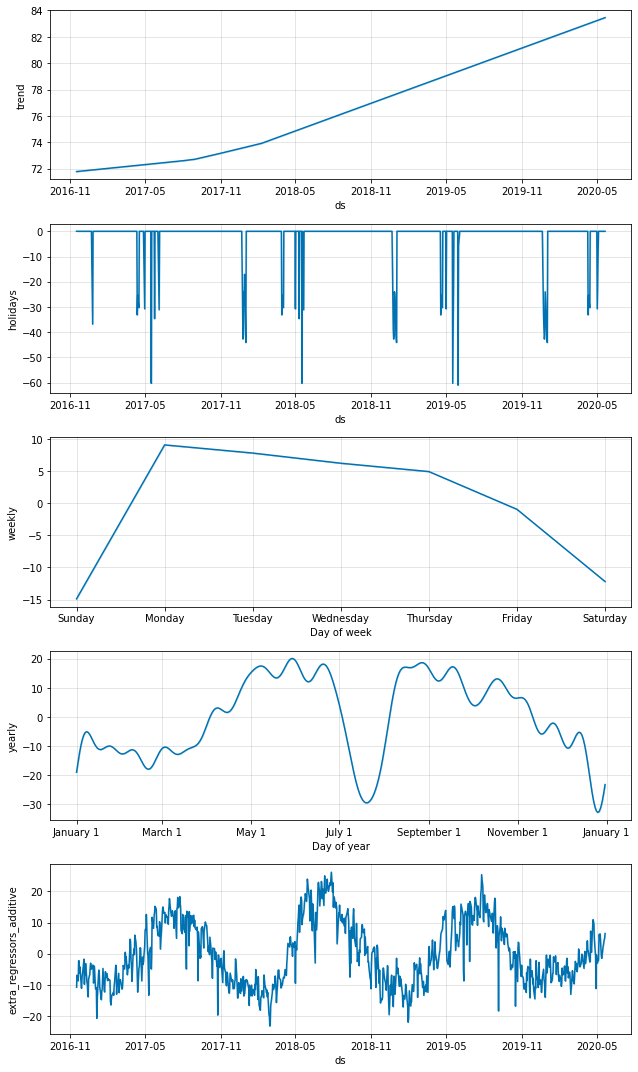

In [27]:
fig = m.plot_components(forecast)

### Making an actual forecast

So, we’re done for now. The last thing we want to do is to make an actual forecast. Remember that we must take the inverse of our Box Cox transformed numbers also and this is how you do it:

In [28]:
# Make a zero days forecast just for plotting
future = m.make_future_dataframe(periods=0, freq='D')
future = future.merge(bikerides, on='ds')
forecast = m.predict(future)

# Transform back to reality from Box Cox
forecast[['yhat', 'yhat_upper', 'yhat_lower']] = forecast[['yhat', 'yhat_upper', 'yhat_lower']].apply(lambda x: inv_boxcox(x, lam))
yinv = inv_boxcox(bikerides['y'], lam)

# Plot the results
fig = go.Figure()
fig.add_trace(go.Scatter(x=bikerides['ds'], y=yinv, name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))

Confirming that the scales are back and usable in the real world.

### Conclusion

In this article, you have learned how to use the Facebook Prophet library to make time series forecasts. We have learned how to use Box Cox transformation and how to add extra regressors and tune Prophet models to perform increasingly better. We started out with a mean percentage absolute error of ~17% and ended up with ~9%, a considerable improvement and a usable result. I hope this article was valuable to you and that you learned something that you can use in your own work.

### Predict 180 days

In [29]:
future = m.make_future_dataframe(periods=180, freq='D')

# add regressor for prediction
future['rain'] = bikerides['rain']
future['temp'] = bikerides['temp']

regressor = []

# find NaN value
for index, row in future.iterrows():
    is_nan_series = row.isnull()
    if is_nan_series.any():
		# NaN values
        regressor = future[(future['ds'] >= row.ds)]
		# original values
        future = future[(future['ds'] < row.ds)]
        break

# last year (same date)
regressor = (regressor['ds'] - pd.DateOffset(years=1)).to_frame()
# merge last year's data('rain' and 'temp')
regressor = regressor.merge(bikerides, on='ds', how='inner')
# reverse year (change current year)
regressor['ds'] = (regressor['ds'] + pd.DateOffset(years=1)).to_frame()
# remove y feature
regressor.drop(['y'], axis=1, inplace=True)
# append regressor('rain' and 'temp')
future = future.append(regressor)

forecast = m.predict(future)

#fig = m.plot(forecast)
#plt.axvline(x=forecast['ds'].max() - pd.Timedelta('180 days'), c='red', lw=2, alpha=0.5, ls='--')

# Transform back to reality from Box Cox
forecast[['yhat', 'yhat_upper', 'yhat_lower']] = forecast[['yhat', 'yhat_upper', 'yhat_lower']].apply(lambda x: inv_boxcox(x, lam))
yinv = inv_boxcox(bikerides['y'], lam)

# Plot the results
fig = go.Figure()
fig.add_trace(go.Scatter(x=bikerides['ds'], y=yinv, name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))

### Saving models

In [30]:
import json
from prophet.serialize import model_to_json

with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model